In [33]:
# import the required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1. HR Analytics

### 1.1 Load and Sample the data

In [34]:
hr = pd.read_csv("./hr_data.csv")

hr["education"].fillna("Missing", inplace = True)
hr["previous_year_rating"].fillna(0, inplace = True)
hr.drop(columns = "employee_id",inplace = True)

from feature_engine.encoding import OneHotEncoder

ohe = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].unique(), 0)}

def encode(train, test, variable, mapping):
    train[variable] = train[variable].map(mapping)
    test[variable] = test[variable].map(mapping)

In [35]:
hr1 = hr[hr["is_promoted"] == 1]
hr0 = hr[hr["is_promoted"] == 0]

hr0_s = hr0.sample(n = len(hr1), random_state= 404).copy()
hr_s = pd.concat([hr1,hr0_s], axis = 0)
hr_s["is_promoted"].value_counts()

1    4668
0    4668
Name: is_promoted, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hr_s.drop('is_promoted', axis=1), 
hr_s['is_promoted'], test_size=0.2, random_state=404)

In [37]:
edu_map = {"Master's & above": 3, 
           "Bachelor's": 2, 
           'Missing': 0, 
           'Below Secondary': 1}

encode(X_train,X_test,"education",edu_map)

ohe.fit(X_train)
X_train  = ohe.transform(X_train)
X_test = ohe.transform(X_test)

In [38]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle= True,random_state= 404)
cv = skf.split(X_train, y_train)

### 1.2 Build the Model(s)

In [39]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
adaRFM = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=9,
                                                         n_estimators=30,
                                                         random_state=404),
                   learning_rate=0.08, n_estimators=60, random_state=404)

In [40]:
from lightgbm import LGBMClassifier
LGBM = LGBMClassifier(importance_type='gain', learning_rate=0.13, n_estimators=40,
               random_state=404, reg_alpha=0.03, reg_lambda=0.06)

### 1.3 Evaluate and Improve the Model(s)

In [41]:
from sklearn.ensemble import VotingClassifier
arr = [("adaRFM", adaRFM),("LGBM", LGBM)]

Svoter = VotingClassifier(arr, voting="soft")
Svoter.fit(X_train,y_train)

VotingClassifier(estimators=[('adaRFM',
                              AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=9,
                                                                                       n_estimators=30,
                                                                                       random_state=404),
                                                 learning_rate=0.08,
                                                 n_estimators=60,
                                                 random_state=404)),
                             ('LGBM',
                              LGBMClassifier(importance_type='gain',
                                             learning_rate=0.13,
                                             n_estimators=40, random_state=404,
                                             reg_alpha=0.03,
                                             reg_lambda=0.06))],
                 voting='soft')

In [42]:
y_test_preds = Svoter.predict(X_test)
y_train_preds = Svoter.predict(X_train)

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

In [44]:
print(classification_report(y_train, y_train_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.94      0.77      0.85      3762
           1       0.80      0.95      0.87      3706

    accuracy                           0.86      7468
   macro avg       0.87      0.86      0.86      7468
weighted avg       0.87      0.86      0.86      7468



In [45]:
print(classification_report(y_test, y_test_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.72      0.80       906
           1       0.78      0.92      0.84       962

    accuracy                           0.82      1868
   macro avg       0.83      0.82      0.82      1868
weighted avg       0.83      0.82      0.82      1868



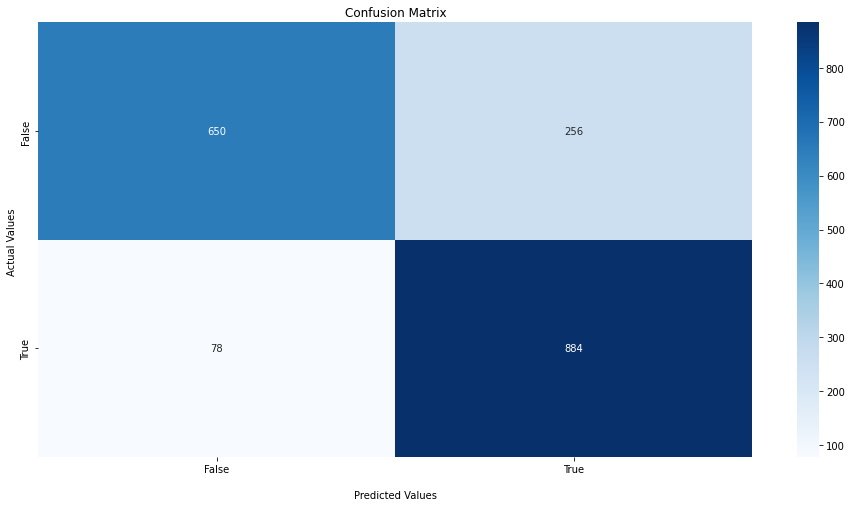

In [46]:
cf_matrix = confusion_matrix(y_test, y_test_preds)

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (16,8))

sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', ax=ax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## 2. Airbnb

### 2.1 Load and Sample the data

In [47]:
ar = pd.read_csv("./listings.csv")
# drop the identifying features, such as Name, id, host_id and host_name
ar.drop(columns =["id","name","host_id"
                 ,"host_name"], inplace =True)

ar["last_review"].fillna(0,inplace = True)
ar["reviews_per_month"].fillna(0,inplace = True)

ar["last_review"] = pd.to_datetime(ar["last_review"])

ar["days_since_last_review"] = (pd.Timestamp("2022-11-10") - ar['last_review']).dt.days
# those with no last_review would have -1days since last review instead, to reflect that it has never recieved a review
ar["days_since_last_review"].replace(to_replace = 19306, value = -1, inplace = True)

ar.drop(columns=["last_review"],inplace= True)

In [48]:
ar_400 = ar[ar["price"] <=400]

In [49]:
ar_400.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_last_review
0,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,0.01,2,365,3307
1,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,0.28,1,365,2876
2,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,0.20,2,365,2597
3,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,0.15,9,353,1187
4,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,0.22,9,355,1201


In [50]:
X_train, X_test, y_train, y_test = train_test_split(ar_400.drop("price", axis=1), 
ar_400["price"], test_size=0.2, random_state=404)

In [51]:
def standardSscale(X_train , X_test):
    from sklearn.preprocessing import StandardScaler
    # set up the scaler
    scaler = StandardScaler()

    # fit the scaler to the train set, it will learn the parameters
    scaler.fit(X_train)

    # transform train and test sets
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    return X_train_scaled , X_test_scaled

# mean target encoding 
from feature_engine.encoding import MeanEncoder
enc = MeanEncoder(variables=["room_type","neighbourhood_group","neighbourhood"])
enc.fit(X_train,y_train)
X_train  = enc.transform(X_train)
X_test = enc.transform(X_test)

c:\Python39\lib\site-packages\feature_engine\encoding\base_encoder.py:193: UserWarning: During the encoding, NaN values were introduced in the feature(s) neighbourhood.
  warnings.warn(


In [52]:
X_test.fillna(-1,inplace=True)
X_train, X_test = standardSscale(X_train, X_test)

### 2.2 Build the Model(s)

In [53]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
adaLBM = AdaBoostRegressor(base_estimator=LGBMRegressor(importance_type='gain',
                                               n_estimators=150,
                                               random_state=404,
                                               reg_alpha=0.05),
                  learning_rate=0.02, loss='exponential', n_estimators=140,
                  random_state=404)

In [54]:
adaLBM.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=LGBMRegressor(importance_type='gain',
                                               n_estimators=150,
                                               random_state=404,
                                               reg_alpha=0.05),
                  learning_rate=0.02, loss='exponential', n_estimators=140,
                  random_state=404)

In [55]:
y_test_preds = adaLBM.predict(X_test)
y_train_preds = adaLBM.predict(X_train)

### 2.3 Evaluate and Improve the Model(s)

In [56]:
from sklearn.metrics import mean_absolute_error

print("MAE Train :",mean_absolute_error(y_train,y_train_preds))
print("MAE Test  :",mean_absolute_error(y_test,y_test_preds))

MAE Train : 25.42354460278218
MAE Test  : 35.36305547897336


In [57]:
from sklearn.metrics import r2_score
print("R^2 Train :",r2_score(y_train,y_train_preds))
print("R^2 Test  :",r2_score(y_test,y_test_preds))

R^2 Train : 0.850554938152108
R^2 Test  : 0.6651963367486933


In [58]:
from sklearn.metrics import mean_squared_error
print("RMSE Train :",np.sqrt(mean_squared_error(y_train,y_train_preds)))
print("RMSE Test  :",np.sqrt(mean_squared_error(y_test,y_test_preds)))

RMSE Train : 33.43695522531871
RMSE Test  : 48.821505754191456
